# RFM Customer Analysis

## Setup/Dependencies 

In [2]:
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# disable chained assignments
pd.options.mode.chained_assignment = None 

In [3]:
# Load our data
df = pd.read_excel('jobs.xlsx')

/home/daniel/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Clean/Explore/Sort Data

In [4]:
# Clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')\
            .str.replace('(', '')\
            .str.replace(')', '')\
            .str.replace('#', 'number')

/tmp/ipykernel_17718/1841012716.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')\


In [5]:
# What are our datatypes?
df.dtypes

job_number                     int64
job_type                      object
job_campaign                  object
campaign_category             object
business_unit                 object
invoice_number                 int64
jobs_total                   float64
completion_date       datetime64[ns]
job_class                     object
summary                       object
customer_id                    int64
customer_name                 object
primary_technician            object
dtype: object

In [6]:
# What is the shape of our data?
df.shape

(16253, 13)

In [7]:
# Any null vales?
df.isnull().values.any()

True

In [8]:
# How many null values and which columns?
df.isnull().sum()

job_number                0
job_type                  0
job_campaign              0
campaign_category     16243
business_unit             0
invoice_number            0
jobs_total                0
completion_date           0
job_class             12431
summary               12324
customer_id               0
customer_name             0
primary_technician       64
dtype: int64

In [9]:
# For this RFM analysis the columns that are showing null values are not usefull
# We DO NOT want to drop the entire row
# If there were null values in a usefull column we would use:
# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)

In [10]:
# Convert completion dates to pd date time
df['completion_date'] = pd.to_datetime(df.completion_date)

# Index DF with 'completion_date' and sort ascending
df = df.sort_values(by='completion_date', ascending=True)
df = df.set_index(df['completion_date'])

## RFM Code

In [11]:
# Create today datetime variable
today = datetime.date.today()

In [12]:
# Create main DF, and only what columns we need
rfm = df[['completion_date', 'customer_id', 'job_number', 'jobs_total']]
rfm.head(1)

,completion_date,customer_id,job_number,jobs_total
completion_date,,,,
2018-06-01,2018-06-01,9931896,50064,49.0


In [13]:
# Recency in RFM DF
rfm['recency'] = pd.to_datetime(today) - pd.to_datetime(rfm.completion_date)
rfm.head(1)

,completion_date,customer_id,job_number,jobs_total,recency
completion_date,,,,,
2018-06-01,2018-06-01,9931896,50064,49.0,1258 days


In [14]:
# Create Recency DF using min, when were we there last?
rfm_r = rfm.groupby(['customer_id']).recency.min().reset_index()
rfm_r.head(1)

,customer_id,recency
0,9931872,215 days


In [15]:
# Create Frequency DF, how many jobs were completed?
rfm_f = rfm.groupby('customer_id').job_number.count().reset_index()
rfm_f.head(1)

,customer_id,job_number
0,9931872,2


In [16]:
# How much money has this customer spent with us? 
rfm_m = rfm.groupby('customer_id').jobs_total.sum().reset_index()
rfm_m.head(1)

,customer_id,jobs_total
0,9931872,384.4


In [17]:
## Merge DFs and created RFMF
rfmf = rfm_r.merge(rfm_f, on = 'customer_id', how = 'outer').merge(rfm_m, on = 'customer_id', how = 'outer')
rfmf.head()

,customer_id,recency,job_number,jobs_total
0,9931872,215 days,2,384.4
1,9931873,84 days,26,4232.5
2,9931874,582 days,2,551.4
3,9931875,162 days,4,197.0
4,9931876,183 days,4,517.8


In [18]:
# Update column names
rfmf.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfmf.head(1)

,customer_id,recency,frequency,monetary
0,9931872,215 days,2,384.4


In [19]:
# Create percentile, slicing dfs into 4ths, then giving each customer a score
rfmf['r_percentile'] = rfmf['recency'].rank(method='first', pct=True,ascending=False)
rfmf['r_score'] = pd.qcut(rfmf['r_percentile'], 4, labels=range(4,0,-1))
rfmf['f_percentile'] = rfmf['frequency'].rank(method='first', pct=True,ascending=True)
rfmf['f_score'] = pd.qcut(rfmf['f_percentile'], 4, labels=range(4,0,-1))
rfmf['m_percentile'] = rfmf['monetary'].rank(method='first', pct=True,ascending=True)
rfmf['m_score'] = pd.qcut(rfmf['m_percentile'], 4, labels=range(4,0,-1))

rfmf.head()

,customer_id,recency,frequency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
0,9931872,215 days,2,384.4,0.571186,2,0.482776,3,0.509927,2
1,9931873,84 days,26,4232.5,0.947395,1,0.999830,1,0.978619,1
2,9931874,582 days,2,551.4,0.321568,3,0.482946,3,0.603767,2
3,9931875,162 days,4,197.0,0.730528,2,0.738334,2,0.365009,3
4,9931876,183 days,4,517.8,0.661632,2,0.738503,2,0.586119,2


In [20]:
# Drop unneeded columns
columns1 = ['r_percentile', 'f_percentile', 'm_percentile']
rfmf.drop(columns1, inplace=True, axis=1)

In [21]:
# Concat scores to create score and score total
rfmf['rfm_score'] = rfmf['r_score'].astype(str) + rfmf['f_score'].astype(str) + rfmf['m_score'].astype(str)
rfmf['rfm_score_total'] = rfmf['r_score'].astype(int) + rfmf['f_score'].astype(int) + rfmf['m_score'].astype(int)

rfmf.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_score_total
0,9931872,215 days,2,384.4,2,3,2,232,7
1,9931873,84 days,26,4232.5,1,1,1,111,3
2,9931874,582 days,2,551.4,3,3,2,332,8
3,9931875,162 days,4,197.0,2,2,3,223,7
4,9931876,183 days,4,517.8,2,2,2,222,6


In [22]:
# Drop unnneeded columns
columns2 = ['r_score', 'f_score', 'm_score']
rfmf.drop(columns2, inplace=True, axis=1)

In [23]:
# Define rfm_level function
def rfm_level(df):
    if df['rfm_score_total'] == 3:
        return 'Champions'
    elif ((df['rfm_score_total'] >= 4) and (df['rfm_score_total'] < 5)):
        return 'Good'
    elif ((df['rfm_score_total'] >= 5) and (df['rfm_score_total'] <= 8)):
        return 'Potential'
    elif ((df['rfm_score_total'] >= 9) ):
        return 'Needs Attention'

In [24]:
# Create a new variable RFM_Level
rfmf['rfm_level'] = rfmf.apply(rfm_level, axis=1)
rfmf.head()

,customer_id,recency,frequency,monetary,rfm_score,rfm_score_total,rfm_level
0,9931872,215 days,2,384.4,232,7,Potential
1,9931873,84 days,26,4232.5,111,3,Champions
2,9931874,582 days,2,551.4,332,8,Potential
3,9931875,162 days,4,197.0,223,7,Potential
4,9931876,183 days,4,517.8,222,6,Potential


## Visualize

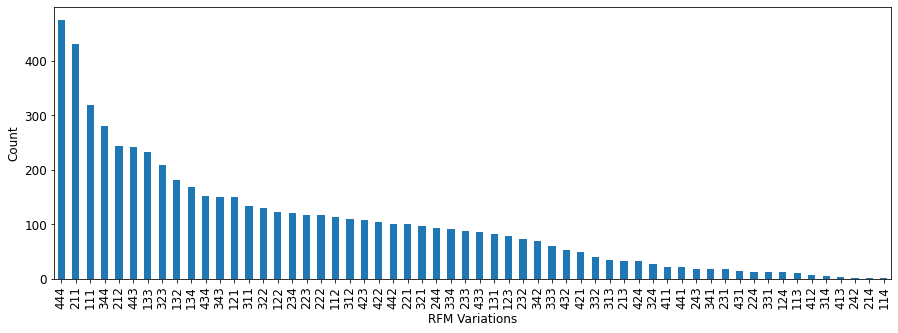

In [25]:
# Plot each possible combination in groups
ax = rfmf['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Variations", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [26]:
# There are so many variations! This is why we create a RFM Score Total

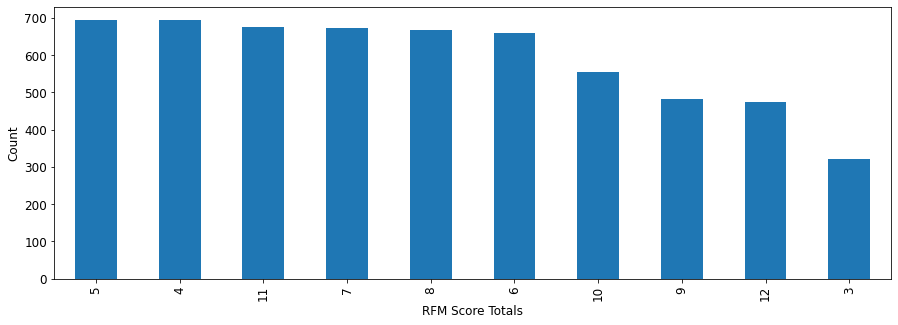

In [27]:
# Plot rfm score totals in groups
ax = rfmf['rfm_score_total'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score Totals", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [28]:
# Still, a lot of variations! And this is why we create RFM Groups

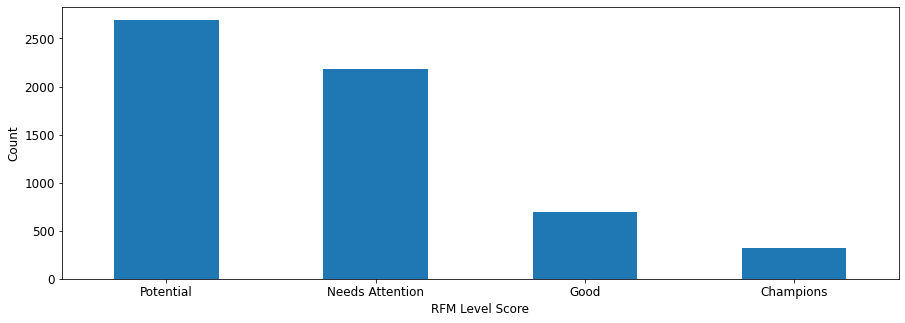

In [29]:
# Plot final groups
ax = rfmf['rfm_level'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Level Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()

rfm_level
Champions           320
Good                695
Needs Attention    2185
Potential          2693
Name: rfm_level, dtype: int64


<AxesSubplot:ylabel='rfm_level'>

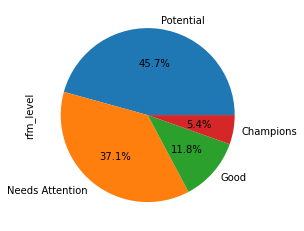

In [30]:
# Totals for each group
totals = rfmf.groupby('rfm_level').rfm_level.count()
print(totals)

rfmf.rfm_level.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4))

## Explore rfm groups

In [31]:
# Get array of our groups
groups = rfmf.rfm_level.unique()

# Use for loop for basic statistics of each group
for group in groups:
    base = rfmf[rfmf.rfm_level==group]
    describe = base.describe()[['recency', 'frequency', 'monetary']]
    print('\n', group, '\n', describe)


 Potential 
                            recency    frequency      monetary
count                         2693  2693.000000   2693.000000
mean   337 days 10:14:23.572224284     2.703305    722.106933
std    274 days 15:02:05.703943972     1.902132    996.428319
min               51 days 00:00:00     1.000000      0.000000
25%              140 days 00:00:00     1.000000    241.000000
50%              196 days 00:00:00     2.000000    502.200000
75%              489 days 00:00:00     3.000000    838.200000
max             1248 days 00:00:00    27.000000  17024.400000

 Champions 
                           recency   frequency      monetary
count                         320  320.000000    320.000000
mean            114 days 08:15:00    7.868750   2846.791500
std    32 days 05:59:52.651444709    3.011206   3152.995821
min              51 days 00:00:00    4.000000    930.400000
25%              85 days 00:00:00    5.000000   1327.012500
50%             118 days 12:00:00    8.000000   1919.9

In [32]:
rfmf.head(1)

,customer_id,recency,frequency,monetary,rfm_score,rfm_score_total,rfm_level
0,9931872,215 days,2,384.4,232,7,Potential


In [33]:
# Create new df for plotting, convert recency column from DateTime to int
plot_df = rfmf[['recency', 'frequency', 'monetary', 'rfm_level']]
plot_df['recency'] = plot_df['recency'].astype(str).apply(lambda x: x.split(' ')[0]).astype(int)

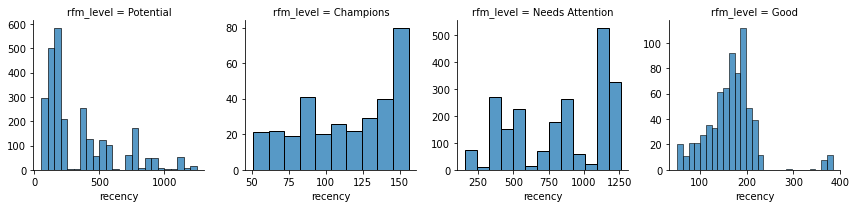

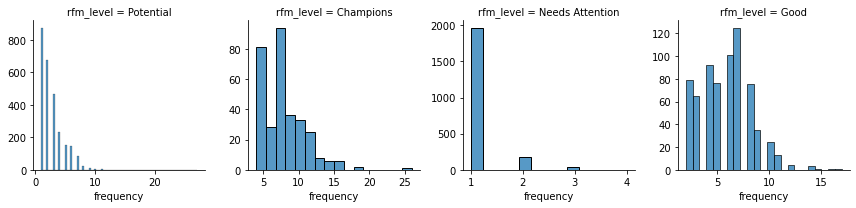

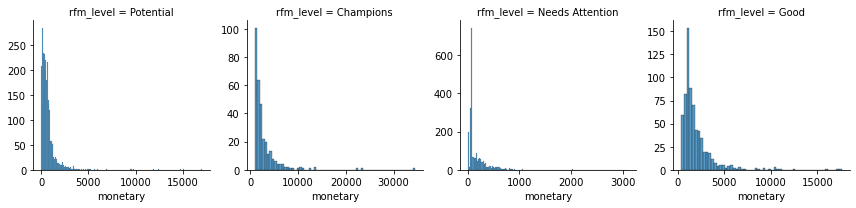

In [123]:
# Histogram plots for each 
plot_cats = ['recency', 'frequency', 'monetary']

for plot in plot_cats:
    hist = sns.FacetGrid(plot_df, col='rfm_level', sharex=False, sharey=False)
    hist.map(sns.histplot, plot)

In [30]:
# As you can see our groups are very different and should be marketed to differently

In [32]:
needs_attention = 'Complimentary System Checkup'
potential = '20% off any repair'
good = 'BOGO Water Saving Head'
champions = 'Due to your loyalty we would like to give you 10% off any of our upgrades!'

In [33]:
# once we are done exporting the data that contains 'customer_id' and 'marketing string' we can then later join
# the dataset using the customer_id column as a key.